In [105]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 16 19:18:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |   3355MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.85 s (started: 2022-01-16 19:18:52 +00:00)


In [107]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.15 s (started: 2022-01-16 19:18:55 +00:00)


In [108]:
!pip install --quiet optuna

time: 3.75 s (started: 2022-01-16 19:19:00 +00:00)


In [109]:
import os
import glob
from tqdm import tqdm
import re 
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

import time
import datetime


from PIL import Image
from PIL import ImageFile
from skimage import io
from skimage.transform import rescale
from skimage.transform import resize


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from xgboost import XGBClassifier #pour xbboost
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
import sklearn.datasets
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler

import optuna # hyeperparam optimization 

time: 18.2 ms (started: 2022-01-16 19:19:04 +00:00)


# Variables

## Paths

In [110]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
hyperparam_dir = root_dir + 'ML_hyperparam/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
export_dir = hyperparam_dir + timestamp + '/'
os.makedirs(export_dir)

time: 11.3 ms (started: 2022-01-16 19:19:04 +00:00)


## Other

In [111]:
# seed
random_seed = 42

# build csv
loop_over_images = True
# min images per family
min_img_per_fam = 4000
# new resolution 
new_res = (24,32) 


# optuna & xgboostoptimiztion
tree_method = 'gpu_hist' if int(os.environ["COLAB_GPU"]) > 0 else 'hist'
n_trials = 50 # number optuna bayesian opt 
scoring = 'f1_micro' # scoring objective function  https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
# XGBOSST inside objective 
n_estimators = 1000 # nombre d'arbre xgboosting MAX qui sera limité par l'early stopping
early_stopping_rounds = 20  # window of the number of epochs over which no improvement is observed


debug = False
# random row picking dans le df initial(avec chemin des fichiers) if true
len_max = 100 if debug else None
# number of trials 
n_trials = 2  if debug else n_trials
# n estimators 
n_estimators = 100  if debug else n_estimators


time: 9.49 ms (started: 2022-01-16 19:19:04 +00:00)


# Load & filter dataset EDA

In [112]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/RAW DATA"
if os.path.exists(main_path)== False :
  !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"

time: 3.54 ms (started: 2022-01-16 19:19:04 +00:00)


In [113]:
df_raw =  pd.read_csv(root_dir + 'image_and_json_data.csv')

time: 1.98 s (started: 2022-01-16 19:19:04 +00:00)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.



In [114]:
#select only 320,240 images with family info
df_raw = df_raw[df_raw['resolution']=='(320, 240)']

time: 61.8 ms (started: 2022-01-16 19:19:06 +00:00)


In [115]:
# drop na 
df_raw = df_raw[df_raw['gbif_info.family'].notna()]
# df.isna().sum()

time: 61.7 ms (started: 2022-01-16 19:19:06 +00:00)


In [116]:
# keep conf level over 90 
df_raw = df_raw.loc[df_raw['gbif_info.confidence']>90]

time: 88.7 ms (started: 2022-01-16 19:19:06 +00:00)


In [117]:
# keep only most common class
top_class = df_raw['gbif_info.class'].value_counts().index[0]
df_raw = df_raw[df_raw['gbif_info.class'] == top_class]

time: 50.2 ms (started: 2022-01-16 19:19:06 +00:00)


In [118]:
#  add a family count for later masking
df_ = pd.DataFrame(df_raw['gbif_info.family'].value_counts().reset_index())
df_.columns = ['gbif_info.family', 'family_count']
df_raw = pd.merge(df_raw, df_, on='gbif_info.family')

time: 505 ms (started: 2022-01-16 19:19:06 +00:00)


In [119]:
# SPECIFIC DRIVE lo laod image from content 
df_raw['file_path'] =df_raw['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                               '/content'))
df_raw['file_path'] =df_raw['file_path'].apply(lambda x: x.replace('\\','/'))

time: 100 ms (started: 2022-01-16 19:19:07 +00:00)


In [120]:
summary = df_raw.copy() #copy for later 
# summary.info()

time: 29.5 ms (started: 2022-01-16 19:19:07 +00:00)


# Create numpy array for ML 

## Loop on images to build csv

In [121]:
def build_feat_array(df,pix_rows,pix_cols): 
    # initiate list to store image
    img_lst = []
    # get data
    np.random.seed(seed=random_seed)
    rdm_idx = np.random.randint(0,len(df),len_max) if debug else [i for i in range(len(df))]
    img_path_lst = [df['file_path'].tolist()[i] for i in rdm_idx] if debug else df['file_path'].tolist()
    img_id_lst = [df['image_id'].tolist()[i] for i in rdm_idx] if debug else df['image_id'].tolist()
    family_lst = [df['gbif_info.family'].tolist()[i] for i in rdm_idx] if debug else df['gbif_info.family'].tolist()
    fam_cnt_lst = [df['family_count'].tolist()[i] for i in rdm_idx] if debug else df['family_count'].tolist()
    # build array and lsits 
    for path in tqdm(img_path_lst): 
        img = io.imread(path) 
#         img  = img.convert('RGB') # revoir comment faire notebook CNN
        img = resize(img, (pix_rows, pix_cols))  # RESIZE usng skimage    
        img_arr = np.array(img) # convert to array 
        img_arr = np.resize(img_arr,pix_rows*pix_cols*3)
        img_arr = img_arr.astype('float16') # to reduce array size 
        img_lst.append(img_arr )

    X = np.array(img_lst) # Convert list to np.array()
    return X, family_lst,img_id_lst,fam_cnt_lst

time: 25.5 ms (started: 2022-01-16 19:19:07 +00:00)


In [122]:
tic1 = time.time()
print('+'*120)
print('The resolution is {}'.format(new_res))
# define img size 
pix_rows,pix_cols = new_res[0], new_res[1]
# build df with filter min 
# filter on number of images per class 
df_path_infos = df_raw[df_raw['family_count']>min_img_per_fam] 
display(df_path_infos['gbif_info.family'].value_counts())
# generate data set with features for ML (image to array) 
X, y,img_id_lst,fam_cnt_lst  = build_feat_array(df_path_infos,pix_rows,pix_cols)
# timer to build dataset 
time_to_build_dataset = time.time() - tic1
# timer 
print('\n il faut {}min pour construire le dataset'.format(round(time_to_build_dataset /60,3)))
print('+'*120)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The resolution is (24, 32)


Russulaceae         6119
Boletaceae          6060
Agaricaceae         5254
Tricholomataceae    4967
Amanitaceae         4769
Strophariaceae      4494
Cortinariaceae      4124
Name: gbif_info.family, dtype: int64

100%|██████████| 35787/35787 [13:32<00:00, 44.05it/s]



 il faut 13.546min pour construire le dataset
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time: 13min 32s (started: 2022-01-16 19:19:07 +00:00)


## Train/test

In [123]:
  ## Convert y
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y)

time: 44.3 ms (started: 2022-01-16 19:32:40 +00:00)


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_seed,stratify=y)
pd.DataFrame(y_test).value_counts()

4    1224
2    1212
0    1051
6     993
1     954
5     899
3     825
dtype: int64

time: 139 ms (started: 2022-01-16 19:32:40 +00:00)


# Optuna

## hyperparam optimization

 Optimization des hyperparam d'XGBboost en utilisant bayesian search avec pruning et early_stopping automatique

Links: 
* https://www.architecture-performance.fr/ap_blog/optuna-xgboost-on-a-tabular-dataset/
* https://stackoverflow.com/questions/48653038/cross-val-score-for-xgboost-with-early-stopping-rounds-returns-indexerror
* https://medium.com/subex-ai-labs/efficient-hyperparameter-optimization-for-xgboost-model-using-optuna-3ee9a02566b1
* https://linuxtut.com/en/3bdae8c1098ced2dea5f/
* https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna
* https://stackoverflow.com/questions/44922749/suggestion-on-speeding-up-xgboost-fitting-in-python
* https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_integration.py
* https://broutonlab.com/blog/efficient-hyperparameter-optimization-with-optuna-framework
* https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/

### Objective function

In [125]:
# n_estimators = 2 
# n_trials = 2 

# # debug 
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30, random_state=random_seed,stratify=y)
# nc = len(set(y_train))
# params = {
#         # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
#         'tree_method': tree_method, 
#          # metric 
#         "objective": "multi:softmax",
#         # "eval_metric": "mlogloss",
#         "num_class":nc,
#         # other 
#         # "verbosity": 0,  # 0 (silent) - 3 (debug)
#         "n_estimators": 20,

#         "seed": random_seed,
#         "n_jobs": -1,
#     }
# model = XGBClassifier(**params)

# model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_train, y_train),(X_val, y_val)],
#             eval_metric="mlogloss",
#             verbose=False,
#             # callbacks=[pruning_callback],
#             early_stopping_rounds=1,
#         )
# preds = model.predict(X_val)
# y_pred = np.rint(preds)
# f1_score(y_val, y_pred, average='micro')

# # retrieve performance metrics
# results = model.evals_result()
# epochs = len(results['validation_0']['mlogloss'])
# # x_axis = range(0, epochs)
# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
# x_axis = range(0, epochs)
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()
# # # plot classification error
# # fig, ax = plt.subplots()
# # ax.plot(x_axis, results['validation_0']['error'], label='Train')
# # ax.plot(x_axis, results['validation_1']['error'], label='Test')
# # ax.legend()
# # plt.ylabel('Classification Error')
# # plt.title('XGBoost Classification Error')
# # plt.show()

time: 8.77 ms (started: 2022-01-16 19:32:40 +00:00)


In [126]:
# new : 
def objective(trial,X,y):
    # pour faire de l'early stopping, on doit definir le validation set 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30, random_state=random_seed,stratify=y)
    nc = len(set(y_train))

    params = {
        # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
        'tree_method': tree_method, 
         # metric 
        "objective": "multi:softmax",
        # "eval_metric": "mlogloss",
        "num_class":nc,
        # other 
        # "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": n_estimators, #  NOMBRE D'ARBRE MAX sera ajusté par early stopping 
        "max_depth": trial.suggest_int("max_depth", 2, 25),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 1000),
        "seed": random_seed,
        "n_jobs": -1,
    }

    model = XGBClassifier(**params)
    # Add a callback for pruning cf optuna 
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-mlogloss") # pruning sur le set d'evaluation 
    # train model
    model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train),(X_val, y_val)], #defini validation_0 & validation_1 dans le dict evals_result() et surout pour le pruning
            eval_metric="mlogloss",
            verbose=False,  # VERBOSE ON if want to see each iter results
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds, # DEF EARLY STOPPING 
        )
    # recupere le nombre de rounds pour future train avec le bon nombre via early stopping et pas celui donné par defaut
    n_estimators_early_stop = len(model.evals_result()['validation_1']['mlogloss']) # https://github.com/optuna/optuna/issues/1169 & https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
    trial.set_user_attr('n_estimators', n_estimators_early_stop) # <=> epoch 
    print('n_estimators_early_stop = {}'.format(n_estimators_early_stop))
    # figure 
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    # plot log loss instead of verbose 
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # Predict Assess f1 score on valid set 
    y_pred  = model.predict(X_val)
    return f1_score(y_val, y_pred, average='micro') 

time: 53.9 ms (started: 2022-01-16 19:32:40 +00:00)


In [127]:
# # old
# def objective(trial,X,y):
#     # pour faire de l'early stopping, on doit definir le validation set 
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30, random_state=random_seed,stratify=y)
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dvalid = xgb.DMatrix(X_val, label=y_val)
#     nc = len(set(y_train))
#     # Setup values for the hyperparameters:
#     param = {
#         # early stopping param 
#       #  'early_stopping_rounds': early_stopping_rounds, # 
#        'eval_set': [[X_val, y_val]],
#       # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
#       'tree_method': tree_method, 
#       # metric 
#         "objective": "multi:softmax",
#         "eval_metric": "mlogloss",
#         "num_class":nc,
#       # other 
#        "n_estimators" : trial.suggest_int('n_estimators', 0, n_estimators), #was 000 but too long 
#       'max_depth':trial.suggest_int('max_depth', 2, 25),
#       'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
#       'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
#       'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
#       'gamma':trial.suggest_int('gamma', 0, 5),
#       'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
#       'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
#       'n_jobs' : -1,
#        'verbose':True
#     }
#     # Add a callback for pruning.
#     pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mlogloss")
#     bst = xgb.train(param,
#                     dtrain,
#                     num_boost_round=num_boost_round,
#                     early_stopping_rounds=early_stopping_rounds, 
#                     evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    
#     preds = bst.predict(dvalid)
#     y_pred = np.rint(preds)

#     return f1_score(y_val, y_pred, average='micro')


time: 4.6 ms (started: 2022-01-16 19:32:40 +00:00)


### Launch study

voir comment faire parallelisation optuna

[I 2022-01-16 19:32:40,668] A new study created in memory with name: no-name-490be4d1-5f13-43be-8d23-e3b7509bbf58


50 trials with 1000 max estimators and early_round_stopping window of 20


/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

n_estimators_early_stop = 785


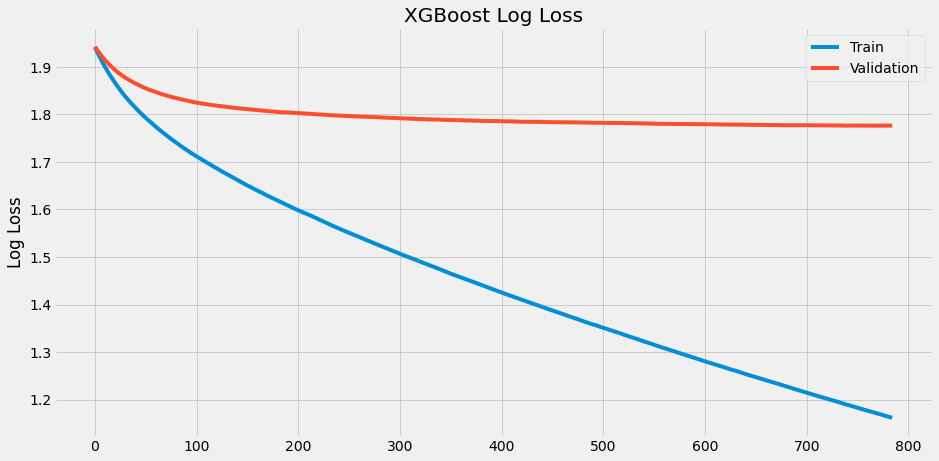

[I 2022-01-16 19:35:48,063] Trial 0 finished with value: 0.2960763767609733 and parameters: {'max_depth': 4, 'learning_rate': 0.036348659067316075, 'colsample_bytree': 0.22270243602779183, 'subsample': 0.6239361078734097, 'alpha': 4.05634505398713, 'lambda': 1.938061567621141e-05, 'min_child_weight': 13.11965857393783}. Best is trial 0 with value: 0.2960763767609733.
n_estimators_early_stop = 448


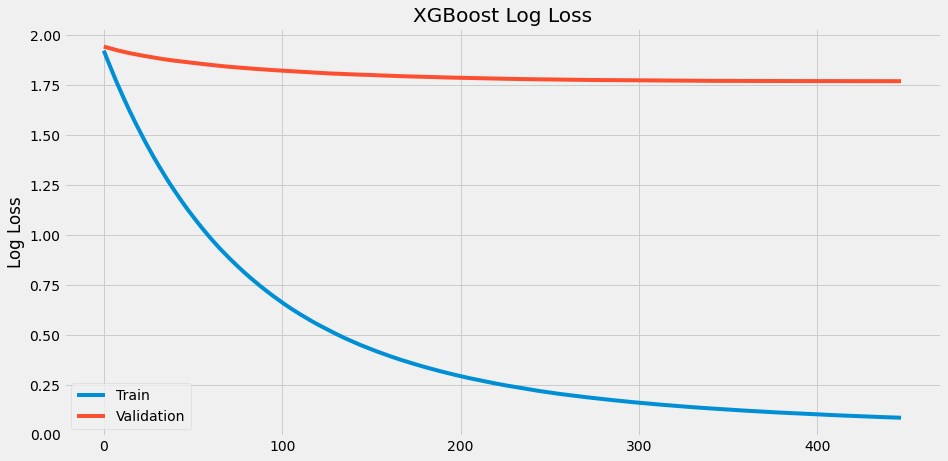

[I 2022-01-16 19:46:38,171] Trial 1 finished with value: 0.30131563627896146 and parameters: {'max_depth': 18, 'learning_rate': 0.019301235423895544, 'colsample_bytree': 0.47040328992682384, 'subsample': 0.7402843936956026, 'alpha': 0.015884917606038752, 'lambda': 0.0006823841372852937, 'min_child_weight': 2.059848808337327}. Best is trial 1 with value: 0.30131563627896146.
n_estimators_early_stop = 1000


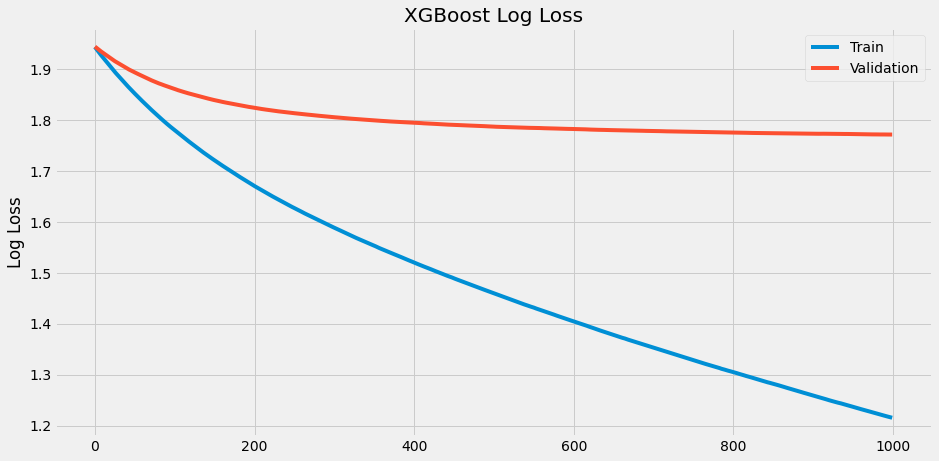

[I 2022-01-16 19:52:58,974] Trial 2 finished with value: 0.29945278845034345 and parameters: {'max_depth': 9, 'learning_rate': 0.011194191945072164, 'colsample_bytree': 0.3217168680411714, 'subsample': 0.41042440350017295, 'alpha': 4.122738056378767, 'lambda': 2.7292609709967746, 'min_child_weight': 36.66838927881418}. Best is trial 1 with value: 0.30131563627896146.
n_estimators_early_stop = 1000


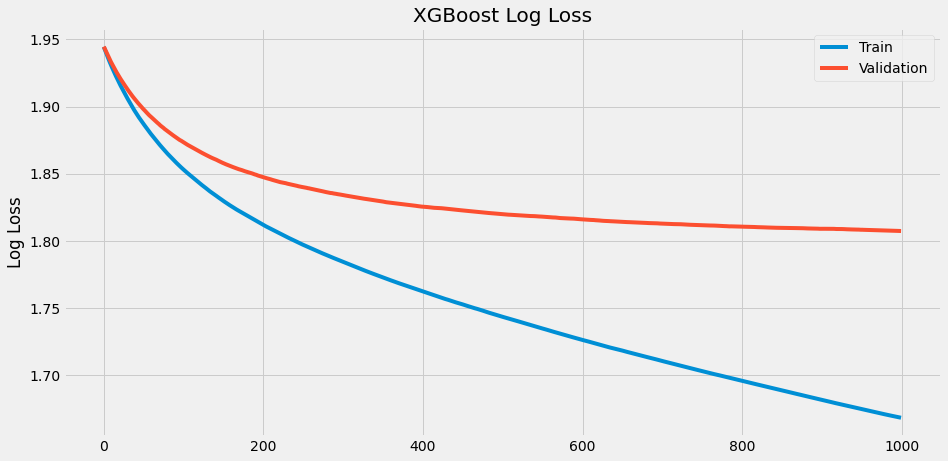

[I 2022-01-16 19:57:30,371] Trial 3 finished with value: 0.27849575037839097 and parameters: {'max_depth': 11, 'learning_rate': 0.02483128557621766, 'colsample_bytree': 0.2629696884805705, 'subsample': 0.5757600591122604, 'alpha': 4.354916158728117, 'lambda': 0.1794927962198468, 'min_child_weight': 528.14473430389}. Best is trial 1 with value: 0.30131563627896146.
[I 2022-01-16 19:57:34,154] Trial 4 pruned. Trial was pruned at iteration 0.
n_estimators_early_stop = 1000


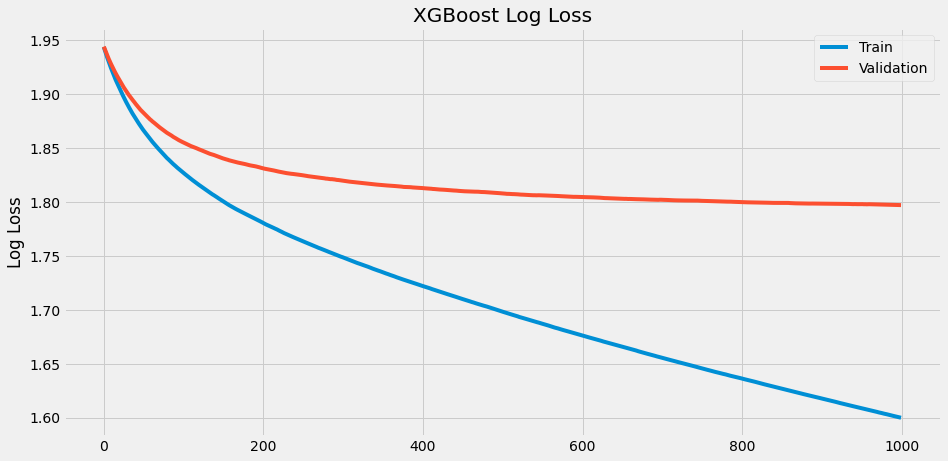

[I 2022-01-16 20:01:22,667] Trial 5 finished with value: 0.28059145418558623 and parameters: {'max_depth': 3, 'learning_rate': 0.030747519375594452, 'colsample_bytree': 0.4014058106739841, 'subsample': 0.4402203671361764, 'alpha': 0.04122089652825914, 'lambda': 0.20089175279713176, 'min_child_weight': 247.90485693840967}. Best is trial 1 with value: 0.30131563627896146.
n_estimators_early_stop = 1000


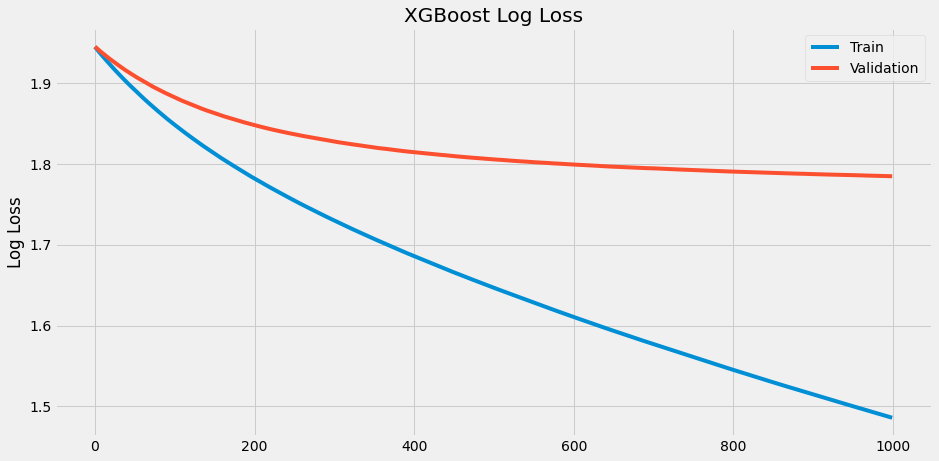

[I 2022-01-16 20:07:54,655] Trial 6 finished with value: 0.29269996507160323 and parameters: {'max_depth': 18, 'learning_rate': 0.008943803320475488, 'colsample_bytree': 0.5308070224561716, 'subsample': 0.5302149043113297, 'alpha': 0.012340104510833191, 'lambda': 7.006179595542129e-08, 'min_child_weight': 111.41256641603213}. Best is trial 1 with value: 0.30131563627896146.
[I 2022-01-16 20:07:57,593] Trial 7 pruned. Trial was pruned at iteration 0.
n_estimators_early_stop = 1000


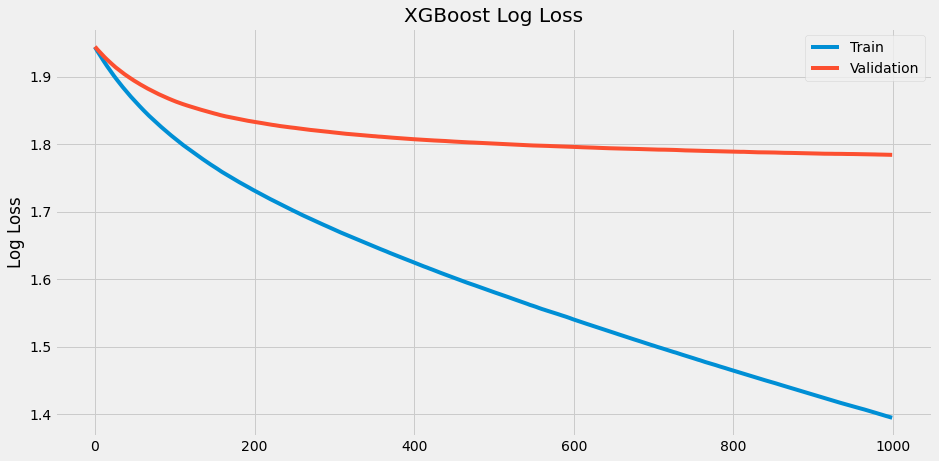

[I 2022-01-16 20:11:59,980] Trial 8 finished with value: 0.29677494469670507 and parameters: {'max_depth': 4, 'learning_rate': 0.015042284443935907, 'colsample_bytree': 0.3054913817798343, 'subsample': 0.5658617917394797, 'alpha': 8.273862342267972, 'lambda': 2.0347592970588975e-07, 'min_child_weight': 9.059154744286994}. Best is trial 1 with value: 0.30131563627896146.
[I 2022-01-16 20:12:02,824] Trial 9 pruned. Trial was pruned at iteration 0.


KeyboardInterrupt: ignored

time: 40min (started: 2022-01-16 19:32:40 +00:00)


In [128]:
print('{} trials with {} max estimators and early_round_stopping window of {}'.format(n_trials,n_estimators,early_stopping_rounds ))
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner( n_startup_trials=3 ) # n_warmup_steps=5, interval_steps=3
    )
study.optimize(lambda trial : objective(trial,X_train,y_train),n_trials= n_trials, show_progress_bar=True) # n_trials

In [129]:
# # old w/o early stopping 
# def objective(trial,X,y):
    
#     # Setup values for the hyperparameters:
#     param = {
#          'tree_method': tree_method,  # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
#        "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
#       'max_depth':trial.suggest_int('max_depth', 2, 25),
#       'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
#       'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
#       'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
#       'gamma':trial.suggest_int('gamma', 0, 5),
#       'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
#       'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
#       'nthread' : -1
#     }
#     model =XGBClassifier(**param)  
#     #Scoring method:



#     return cross_val_score(model, X, y, cv=3, n_jobs=None).mean()

time: 4.5 ms (started: 2022-01-16 20:12:51 +00:00)


## Plot study 

To access the results of all trials, you can use `study.trials_dataframe`, which shows the details of trials as a pandas dataframe.

In [130]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_subsample,user_attrs_n_estimators,state
0,0,0.296076,2022-01-16 19:32:40.712167,2022-01-16 19:35:48.061023,0 days 00:03:07.348856,4.056345,0.222702,1.938062e-05,0.036349,4,13.119659,0.623936,785.0,COMPLETE
1,1,0.301316,2022-01-16 19:35:48.071859,2022-01-16 19:46:38.170023,0 days 00:10:50.098164,0.015885,0.470403,6.823841e-04,0.019301,18,2.059849,0.740284,448.0,COMPLETE
2,2,0.299453,2022-01-16 19:46:38.181884,2022-01-16 19:52:58.972911,0 days 00:06:20.791027,4.122738,0.321717,2.729261e+00,0.011194,9,36.668389,0.410424,1000.0,COMPLETE
3,3,0.278496,2022-01-16 19:52:58.979105,2022-01-16 19:57:30.370066,0 days 00:04:31.390961,4.354916,0.262970,1.794928e-01,0.024831,11,528.144734,0.575760,1000.0,COMPLETE
4,4,1.941065,2022-01-16 19:57:30.376839,2022-01-16 19:57:34.154721,0 days 00:00:03.777882,0.816426,0.479648,1.492957e-03,0.033567,13,5.537252,0.713973,NaN,PRUNED
5,5,0.280591,2022-01-16 19:57:34.165078,2022-01-16 20:01:22.666339,0 days 00:03:48.501261,0.041221,0.401406,2.008918e-01,0.030748,3,247.904857,0.440220,1000.0,COMPLETE
6,6,0.292700,2022-01-16 20:01:22.673234,2022-01-16 20:07:54.653667,0 days 00:06:31.980433,0.012340,0.530807,7.006180e-08,0.008944,18,111.412566,0.530215,1000.0,COMPLETE
7,7,1.943933,2022-01-16 20:07:54.662971,2022-01-16 20:07:57.593867,0 days 00:00:02.930896,0.022781,0.241183,3.029224e-04,0.038215,2,271.086316,0.789190,NaN,PRUNED
8,8,0.296775,2022-01-16 20:07:57.602163,2022-01-16 20:11:59.978464,0 days 00:04:02.376301,8.273862,0.305491,2.034759e-07,0.015042,4,9.059155,0.565862,1000.0,COMPLETE
9,9,1.943537,2022-01-16 20:11:59.986371,2022-01-16 20:12:02.824412,0 days 00:00:02.838041,0.039165,0.256013,1.471729e-08,0.032379,3,10.432739,0.592262,NaN,PRUNED


time: 55 ms (started: 2022-01-16 20:12:52 +00:00)


In [131]:
optuna.visualization.plot_optimization_history(study)

time: 205 ms (started: 2022-01-16 20:12:52 +00:00)


In [132]:
optuna.visualization.plot_intermediate_values(study)

time: 704 ms (started: 2022-01-16 20:12:52 +00:00)


In [133]:
optuna.visualization.plot_slice(study)

time: 400 ms (started: 2022-01-16 20:12:53 +00:00)


In [134]:
optuna.visualization.plot_contour(study)

time: 2.52 s (started: 2022-01-16 20:12:54 +00:00)


In [135]:
optuna.visualization.plot_parallel_coordinate(study)

time: 203 ms (started: 2022-01-16 20:12:56 +00:00)


In [136]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

time: 562 ms (started: 2022-01-16 20:12:56 +00:00)


# best trial and param + retrain on whole X_train

In [137]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
# Get number of trees 
bst_study_nb = study.best_trial.number
n_estimators_early_stop = int(study.trials_dataframe().loc[bst_study_nb,'user_attrs_n_estimators'])
n_estimators_early_stop

Best trial: score 0.30131563627896146,
params {'max_depth': 18, 'learning_rate': 0.019301235423895544, 'colsample_bytree': 0.47040328992682384, 'subsample': 0.7402843936956026, 'alpha': 0.015884917606038752, 'lambda': 0.0006823841372852937, 'min_child_weight': 2.059848808337327}


448

time: 18.5 ms (started: 2022-01-16 20:12:57 +00:00)


In [141]:
# add number of trees to param set 
best_mod= XGBClassifier(**study.best_params,
                         n_estimators = n_estimators_early_stop , # to set number of tree found using early stopping
                        verbosity = 2,
                        tree_method=tree_method,
                        n_jobs=-1) 
best_mod.get_params


<bound method XGBModel.get_params of XGBClassifier(alpha=0.015884917606038752, colsample_bytree=0.47040328992682384,
              lambda=0.0006823841372852937, learning_rate=0.019301235423895544,
              max_depth=18, min_child_weight=2.059848808337327,
              n_estimators=448, n_jobs=-1, subsample=0.7402843936956026,
              tree_method='gpu_hist', verbosity=2)>

time: 12.7 ms (started: 2022-01-16 20:30:17 +00:00)


In [142]:
# fit 
best_mod.fit(X_train, y_train,verbose=True)

XGBClassifier(alpha=0.015884917606038752, colsample_bytree=0.47040328992682384,
              lambda=0.0006823841372852937, learning_rate=0.019301235423895544,
              max_depth=18, min_child_weight=2.059848808337327,
              n_estimators=448, n_jobs=-1, objective='multi:softprob',
              subsample=0.7402843936956026, tree_method='gpu_hist',
              verbosity=2)

time: 16min 19s (started: 2022-01-16 20:30:20 +00:00)


# Assess on test dataset

In [143]:
# Prédiction sur l'échantillon de test
test_pred = best_mod.predict(X_test)
# generate report 
print(classification_report(y_test, test_pred))
report = classification_report(y_test, test_pred, output_dict=True, zero_division=0) # ZERO DIVISION pour éviter warning mode debug 
report = pd.DataFrame(report).transpose()

              precision    recall  f1-score   support

           0       0.32      0.34      0.33      1051
           1       0.35      0.27      0.31       954
           2       0.31      0.52      0.39      1212
           3       0.27      0.16      0.20       825
           4       0.34      0.39      0.36      1224
           5       0.32      0.24      0.28       899
           6       0.33      0.21      0.26       993

    accuracy                           0.32      7158
   macro avg       0.32      0.31      0.30      7158
weighted avg       0.32      0.32      0.31      7158

time: 1.8 s (started: 2022-01-16 20:46:42 +00:00)


# Feat importance

XGBRegressor.get_booster().get_score(importance_type='weight') returns occurrences of the features in splits. If you divide these occurrences by their sum, you'll get Item 1. Except here, features with 0 importance will be excluded.

In [144]:
feat_imp = pd.DataFrame.from_dict(best_mod.get_booster().get_score(importance_type='weight'),orient='index', columns = ['imp'])
feat_imp = feat_imp.sort_values(by=['imp'], ascending=[False])
feat_imp

,imp
f1105,1371
f1101,1348
f1005,1342
f1010,1300
f1201,1269
...,...
f274,466
f263,457
f311,456
f175,455


time: 5.85 s (started: 2022-01-16 20:46:44 +00:00)


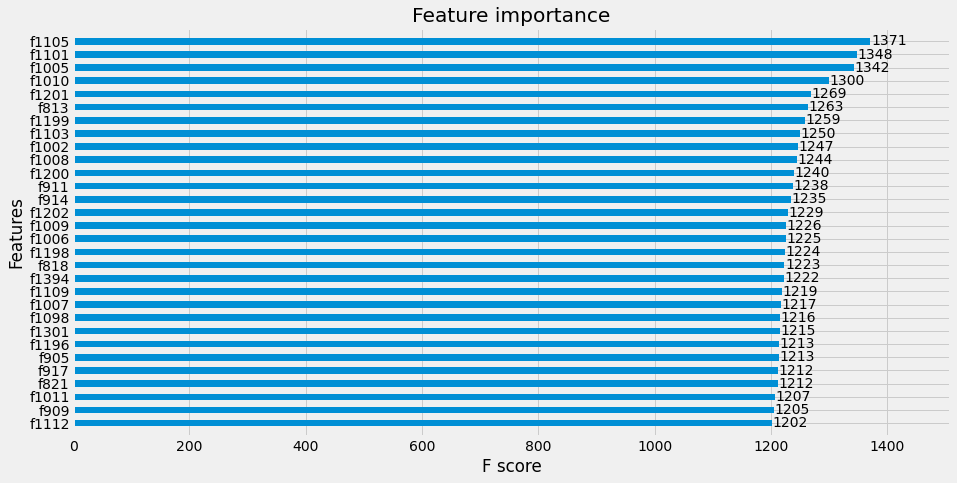

time: 6.37 s (started: 2022-01-16 20:46:49 +00:00)


In [145]:
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(best_mod,max_num_features=30, height = 0.5)

## Plot important pixs as images

In [146]:
# build empty df with X shape  pix  (car feta imp ne donne pas tjs une valeur à tous les pixs )
pixs = [pix for pix in range((X.shape[1]))]
empty_df_ = pd.DataFrame(pixs, columns = ['pix'])
# merge with feat on pix col 
feat_imp['pix'] = feat_imp.index
feat_imp['pix'] = feat_imp['pix'].str[1:].astype('int32')
# join on empty_df_
feat_imp = pd.merge(empty_df_,feat_imp,how='left')
feat_imp = feat_imp.fillna(feat_imp.min())
display(feat_imp)
pix_sorted_imp = feat_imp['imp'].values
print(pix_sorted_imp)

,pix,imp
0,0,887
1,1,735
2,2,735
3,3,732
4,4,581
...,...,...
2299,2299,702
2300,2300,665
2301,2301,817
2302,2302,766


[887 735 735 ... 817 766 764]
time: 40.3 ms (started: 2022-01-16 20:46:56 +00:00)


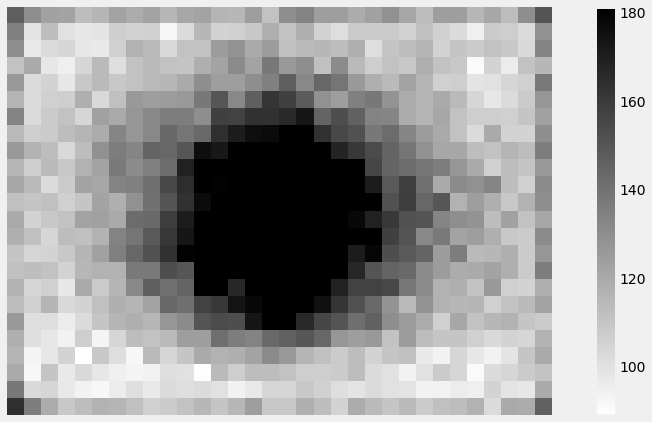

In [ ]:
# extarct les canaux and plot each one 
feat_imp_arr = pix_sorted_imp.reshape(pix_rows, pix_cols, 3).astype('float64') # resize array RGB like 
feat_imp_arr *= 255.0/feat_imp_arr.max() #norm sur 255 cf https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
b, g, r    = feat_imp_arr[:, :, 0], feat_imp_arr[:, :, 1], feat_imp_arr[:, :, 2]
for arr in [b, g, r ]:
  feat_imp_img = Image.fromarray(arr).convert('L') # creat image & convert to gray scale 
  plt.axis('off') 
  plt.imshow(feat_imp_img,origin="lower",cmap = 'gray_r', interpolation='nearest', vmax= np.quantile(feat_imp_arr,0.90)) # plot inverse color map 
  plt.colorbar()
  plt.show()


In [ ]:
# Mean des 3 canaux  
feat_imp_arr = pix_sorted_imp.reshape(pix_rows, pix_cols, 3).astype('float64') # resize array RGB like
feat_imp_arr *= 255.0/feat_imp_arr.max()  #norm sur 255 cf https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
b, g, r    = feat_imp_arr[:, :, 0], feat_imp_arr[:, :, 1], feat_imp_arr[:, :, 2]
mean_bgr_arr = (b+g+r)/3
feat_imp_img = Image.fromarray(mean_bgr_arr).convert('L') # creat image & convert to gray scale 
plt.axis('off') 
plt.imshow(feat_imp_img,origin="lower",cmap = 'gray_r', interpolation='nearest',vmax= np.quantile(mean_bgr_arr,0.9)) # plot inverse color map 
plt.colorbar()
plt.show()

# Questions : 
* quelle metric ? 
* best way to build the X array w/o too much memory consumption 
* why f0 such importance

#To do
  * def scorer f1 micro dans xgboost https://stackoverflow.com/questions/35400372/using-f-score-in-xgb 
  * construire X et y en local + upload to drive pour éviter de rebalayer img à chaque fois 
  * quel f1 score ? micro , macro 
  * difference loss vs metric
  * rebalance data : comment ? : https://www.py4u.net/discuss/2021664
  * replot autres importances
  * define mask to keep only pix d'interet !

In [ ]:
!kill -9 -1